In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# Preproc

In [2]:
import os
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_Preprcess_data(loading_method, image_size=(128, 128), max_images_per_class =None, target_per_class=10000):
    """
    Loads and preprocesses a breast cancer histopathology image dataset for CNN models.

    The function:
        - Loads all images from benign and malignant folders
        - Resizes and normalizes images
        - Applies augmentation to classes until each has `target_per_class` samples
        - One-hot encodes labels
        - Shuffles and splits into train/val/test sets

    Parameters
    ----------
    loading_method : str
        Either 'colab' or 'direct'.
    image_size : tuple of int
        Target size (H, W) for resizing images.
    max_images_per_class : int or None
        Maximum number of images to load per class. Useful for limiting dataset size during testing.
    target_per_class : int
        Number of images to have per class after augmentation.

    Returns
    -------
    X_train : np.ndarray
    y_train : np.ndarray
    X_val : np.ndarray
    y_val : np.ndarray
    X_test : np.ndarray
    y_test : np.ndarray
    """

    # Select path to dataset depending on running environment
    if loading_method == 'colab':
        # Path for Google Colab
        data_path = "/content/drive/MyDrive/breast_project/breast_cancer_dataset"
    elif loading_method == 'direct':
        # Local or direct path
        data_path = "raw_data/breast_cancer/BreaKHis_Total_dataset"
    else:
        raise ValueError("loading_method must be either 'colab' or 'direct'.")

    imgs = []    # to store image arrays
    labels = []  # to store corresponding class labels

    # Dictionary mapping class names to numeric labels
    classes = {'benign': 0, 'malignant': 1}

    # Define augmentation pipeline
    augmenter = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x + tf.random.uniform([], -0.1, 0.1), 0.0, 1.0)),  # brightness
    ])

    # Loop through each class (benign or malignant)
    for cl, label in classes.items():
        class_dir = os.path.join(data_path, cl)

        # List all image filenames in the class directory
        images_path = [
            f for f in os.listdir(class_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        # If max_images_per_class is set, limit how many images to load
        if max_images_per_class:
            images_path = images_path[:max_images_per_class]

        original_images = []

        # Iterate over each image file in this class
        for img_name in tqdm(images_path, desc=f"Loading {cl} images"):
            img_path = os.path.join(class_dir, img_name)

            try:
                img = Image.open(img_path).convert('RGB').resize(image_size)
                original_images.append(np.array(img) / 255.0)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")


        # Augment until we reach target_per_class
        current_count = len(original_images)
        augmented_images = []

        if current_count < target_per_class:
            needed = target_per_class - current_count
            print(f"Augmenting {classes}: Need {needed} more images...")

            # Convert to tensor
            base_imgs = tf.convert_to_tensor(original_images)
            base_imgs = tf.image.resize(base_imgs, image_size)

            i = 0
            while len(augmented_images) < needed:
                batch = augmenter(base_imgs, training=True).numpy()
                for idx, img in enumerate(batch):
                    augmented_images.append(img)

                    # Save the augmented image
                    #save_augmented_image(img, class_dir, cl, len(original_images) + len(augmented_images))

                    if len(augmented_images) >= needed:
                        break


        # Combine original and augmented
        total_class_imgs = np.concatenate([original_images, augmented_images], axis=0)
        total_class_labels = np.full((target_per_class,), label)

        imgs.extend(total_class_imgs)
        labels.extend(total_class_labels)

    # Convert to arrays
    X = np.array(imgs, dtype=np.float32)
    y = to_categorical(np.array(labels), num_classes=2)

    # Shuffle
    indices = np.random.permutation(len(X))
    X, y = X[indices], y[indices]

    # Split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=1/6, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=np.argmax(y_temp, axis=1), random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test, 2


In [3]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_Preprcess_data('colab')

Loading benign images: 100%|██████████| 2479/2479 [08:44<00:00,  4.73it/s]


Augmenting {'benign': 0, 'malignant': 1}: Need 7521 more images...


Loading malignant images: 100%|██████████| 5304/5304 [13:16<00:00,  6.66it/s]


Augmenting {'benign': 0, 'malignant': 1}: Need 4696 more images...


In [4]:
datasets = {
    'Train set': y_train,
    'Validation set': y_val,
    'Test set': y_test}

for name, y_data in datasets.items():
    counts = np.sum(y_data, axis=0)
    print(f"{name}:")
    print(f"  Benign: {int(counts[0])}")
    print(f"  Malignant: {int(counts[1])}")
    print(f"  Total: {int(np.sum(counts))}\n")


Train set:
  Benign: 6666
  Malignant: 6666
  Total: 13332

Validation set:
  Benign: 1667
  Malignant: 1667
  Total: 3334

Test set:
  Benign: 1667
  Malignant: 1667
  Total: 3334



# Model

In [5]:
# Started from updated base model and unfroze last convolutional block
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

IMG_SIZE = 128

def build_vgg16_model_unfreeze_2(img_size=IMG_SIZE, learning_rate=0.00001):
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_tensor=Input(shape=(img_size, img_size, 3))
    )

    # Freeze VGG16 base layers
    for layer in base_model.layers:
      layer.trainable = False

    #Unfreeze only the last convolutional block (block 5) for fine-tuning
    for layer in base_model.layers:
      if 'block5' in layer.name:
        layer.trainable = True

    # Add custom classification head (based on what we did for the manual architecture)
    from tensorflow.keras.layers import BatchNormalization

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(2, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name="precision"), Recall(name='recall')]
    )

    return model

In [6]:
model_unfreeze_2 = build_vgg16_model_unfreeze_2(img_size=128, learning_rate=0.00001)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

modelCheckpoint = ModelCheckpoint("model.keras", save_best_only=True, monitor='val_loss', mode='min')
LRreducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
EarlyStopper = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history_unfreeze = model_unfreeze_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[modelCheckpoint, LRreducer, EarlyStopper]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


417/417 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.5810 - loss: 0.8105 - precision: 0.5810 - recall: 0.5810 - val_accuracy: 0.7825 - val_loss: 0.4662 - val_precision: 0.7825 - val_recall: 0.7825 - learning_rate: 1.0000e-05
Epoch 2/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.7740 - loss: 0.4830 - precision: 0.7740 - recall: 0.7740 - val_accuracy: 0.8377 - val_loss: 0.3735 - val_precision: 0.8377 - val_recall: 0.8377 - learning_rate: 1.0000e-05
Epoch 3/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.8199 - loss: 0.4011 - precision: 0.8199 - recall: 0.8199 - val_accuracy: 0.8620 - val_loss: 0.3271 - val_precision: 0.8620 - val_recall: 0.8620 - learning_rate: 1.0000e-05
Epoch 4/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.8523 - loss: 0.3557 - precision: 0.8523 - recall: 0.8523 - val_accuracy: 0.8695 - val_loss: 0.3064 - val_precision: 0.8695 - val_recall: 0.8695 - learning_rate: 1.0000e-05
Epoch 5/30
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/st

In [8]:
history_unfreeze.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

In [9]:
best_epoch2 = history_unfreeze.history['val_loss'].index(min(history_unfreeze.history['val_loss']))

print(f"Best Epoch: {best_epoch2 + 1}")
print(f"Best Validation Loss: {history_unfreeze.history['val_loss'][best_epoch2]:.4f}")
print(f"Best Validation Accuracy: {history_unfreeze.history['val_accuracy'][best_epoch2]:.4f}")
print(f"Best Validation Precision: {history_unfreeze.history['val_precision'][best_epoch2]:.4f}")
print(f"Best Validation Recall: {history_unfreeze.history['val_recall'][best_epoch2]:.4f}")


Best Epoch: 16
Best Validation Loss: 0.2253
Best Validation Accuracy: 0.9253
Best Validation Precision: 0.9253
Best Validation Recall: 0.9253


# Plots

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


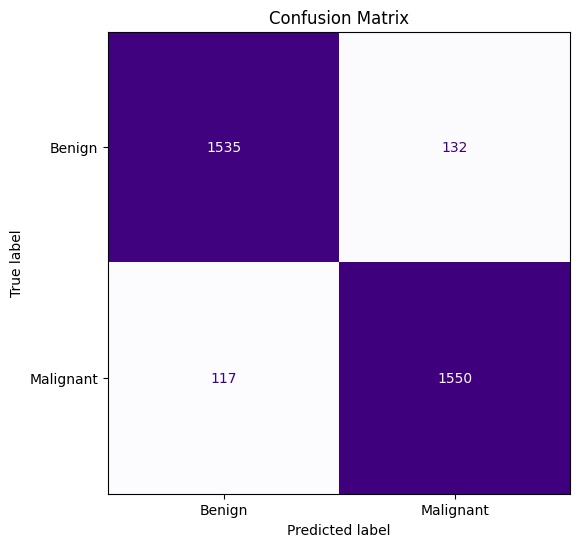

In [10]:
# Saves Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict on validation set
y_pred = model_unfreeze_2.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

# Plot and save
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Purples', colorbar=False)
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", bbox_inches='tight')
plt.show()


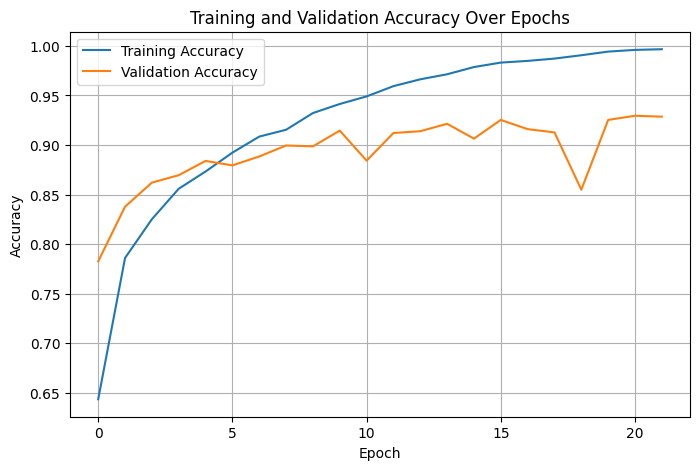

In [11]:
# Plot training and validation accuracy
plt.figure(figsize=(8,5))
plt.plot(history_unfreeze.history['accuracy'], label='Training Accuracy')
plt.plot(history_unfreeze.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("training_curve.png", bbox_inches='tight')
plt.show()


# Predictions

In [13]:
# Get raw predictions for your validation set
preds = model_unfreeze_2.predict(X_val)

# Convert softmax output to class indices
pred_classes = np.argmax(preds, axis=1)

# Show sample predictions and counts
print("Sample predictions:", pred_classes[:20])
print("Unique predicted classes:", dict(zip(*np.unique(pred_classes, return_counts=True))))

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Sample predictions: [0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1]
Unique predicted classes: {np.int64(0): np.int64(1652), np.int64(1): np.int64(1682)}
